In [1]:
from sodapy import Socrata
import pandas as pd

# Conexión a la API de Socrata
client = Socrata("www.datos.gov.co", None)

# ID del dataset: fbht-2fzd
dataset = "fbht-2fzd"
query = """
        SELECT anio_despacho,
               mes_despacho,
               producto,
               SUM(volumen_despachado) as volumen_total
        WHERE anio_despacho in ('2023', '2024', '2025')
          AND subtipo_comprador = 'ESTACION DE SERVICIO AUTOMOTRIZ'
          AND producto != 'DIESEL MARINO'
          AND fecha_despacho <= '2025-06-30'
        GROUP BY anio_despacho, mes_despacho, producto
        ORDER BY anio_despacho, mes_despacho, producto \
        """
consumo = client.get(dataset, query=query)
df_consumo = pd.DataFrame.from_records(consumo)
df_consumo.to_csv('consumo_23fq_24fq_25q2.csv', index=False)
print(len(df_consumo))

90


In [2]:
# 1. Ensure your volume is actually numeric
df_consumo['volumen_total'] = pd.to_numeric(df_consumo['volumen_total'], errors='coerce')

# 2. Make sure month is integer (in case it’s still a string)
df_consumo['mes_despacho'] = df_consumo['mes_despacho'].astype(int)

# 3. Map month to quarter
df_consumo['quarter'] = ((df_consumo['mes_despacho'] - 1) // 3 + 1).map(lambda q: f"Q{q}")

# 4. Group by year, quarter, product and sum
consumo_q_23fq_24fq_25q2 = (
    df_consumo
    .groupby(['anio_despacho', 'quarter', 'producto'], as_index=False)
    .agg(volumen_total=('volumen_total', 'sum'))
)

# 5. (Optional) save to CSV
consumo_q_23fq_24fq_25q2.to_csv('consumo_q_23fq_24fq_25q2.csv', index=False)

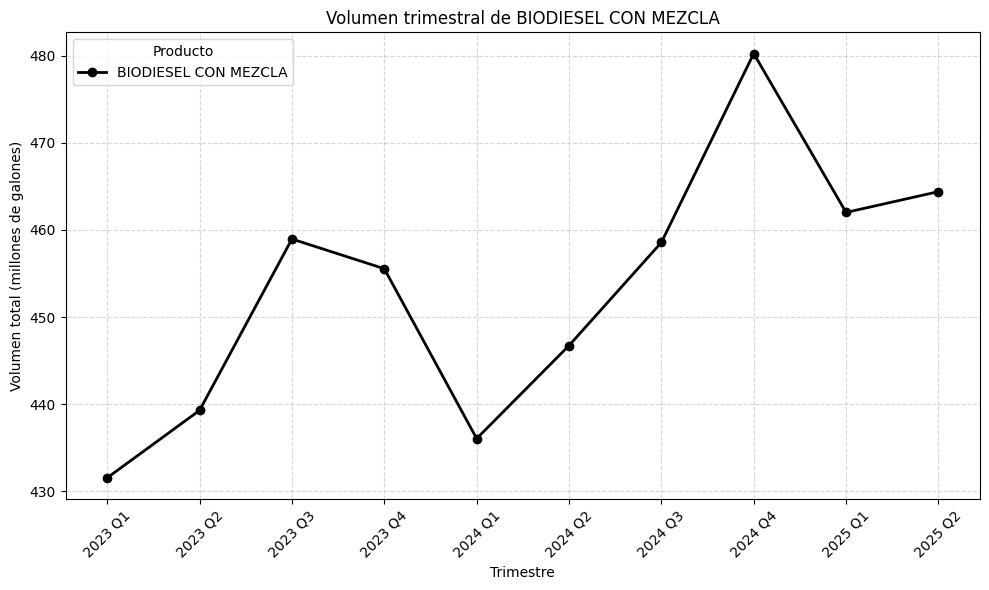

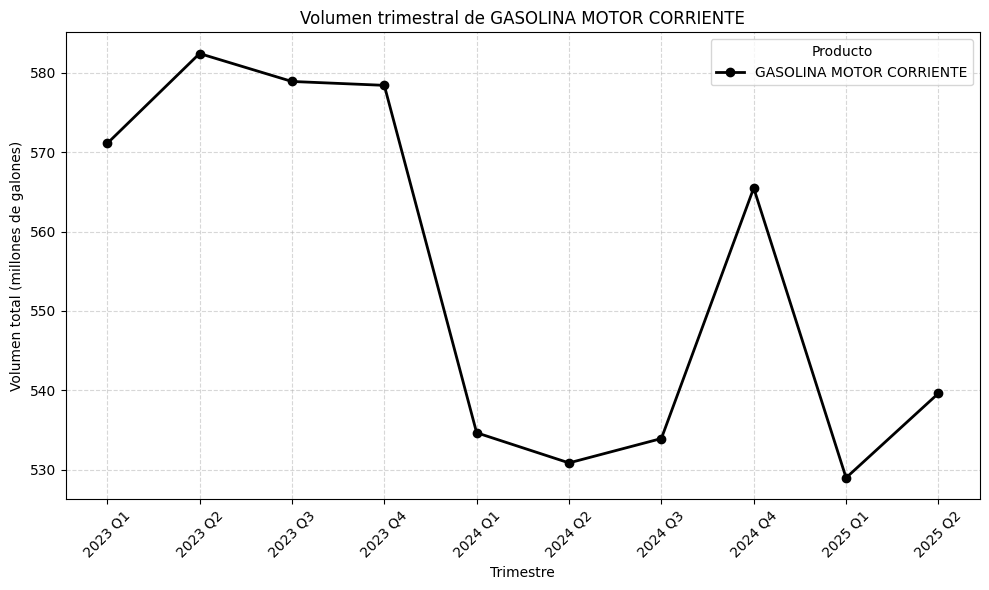

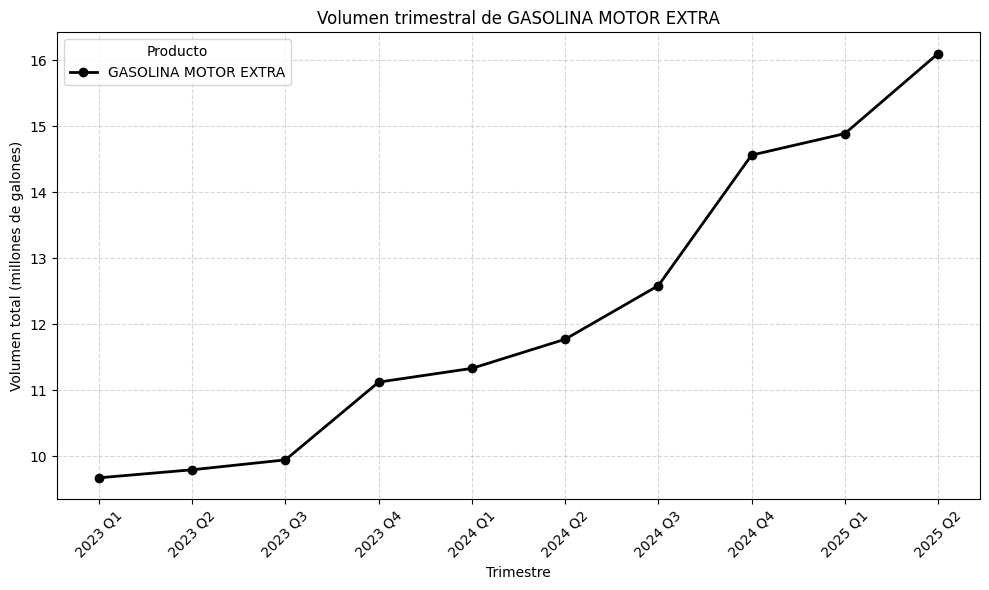

In [3]:
import matplotlib.pyplot as plt

# 1. Asegúrate de que está ordenado cronológicamente
consumo_q_23fq_24fq_25q2 = consumo_q_23fq_24fq_25q2.sort_values(['anio_despacho', 'quarter'])

# 2. Mapeos de nombre en leyenda (español) y color por producto
nombre_leyenda = {
    'Gasolina Corriente': 'Gasolina Corriente',
    'Gasolina Extra': 'Gasolina Extra',
    'Biodiésel':      'Biodiésel'
}
colores = {
    'Gasolina Corriente': 'green',
    'Gasolina Extra':     'gray',
    'Biodiésel':          'blue'
}

# 3. Bucle para dibujar cada producto
for prod in consumo_q_23fq_24fq_25q2['producto'].unique():
    data = consumo_q_23fq_24fq_25q2[consumo_q_23fq_24fq_25q2['producto'] == prod]

    # Etiquetas del eje X: "2023 Q1", "2023 Q2", …
    trimestres = [f"{y} {q}" for y, q in zip(data['anio_despacho'], data['quarter'])]

    # Volumen en millones de galones
    volumen_millones = data['volumen_total'] / 1e6

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        trimestres,
        volumen_millones,
        marker='o',
        linewidth=2,
        color=colores.get(prod, 'black'),
        label=nombre_leyenda.get(prod, prod)
    )

    ax.set_title(f'Volumen trimestral de {nombre_leyenda.get(prod, prod)}')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Volumen total (millones de galones)')
    ax.legend(title='Producto')
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [4]:
# 1. Asegúrate de que está ordenado cronológicamente
consumo_q_23fq_24fq_25q2 = consumo_q_23fq_24fq_25q2.sort_values(['anio_despacho', 'quarter'])

# 2. Mapeos de nombre en leyenda (español) y color por producto
nombre_leyenda = {
    'Gasolina Corriente': 'Gasolina Corriente',
    'Gasolina Extra': 'Gasolina Extra',
    'Biodiésel': 'Biodiésel'
}
colores = {
    'Gasolina Corriente': 'green',
    'Gasolina Extra': 'gray',
    'Biodiésel': 'blue'
}

# 3. Bucle para dibujar cada producto
for prod in consumo_q_23fq_24fq_25q2['producto'].unique():
    data = consumo_q_23fq_24fq_25q2[consumo_q_23fq_24fq_25q2['producto'] == prod]

    trimestres = [f"{y} {q}" for y, q in zip(data['anio_despacho'], data['quarter'])]
    volumen_millones = data['volumen_total'] / 1e6

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        trimestres,
        volumen_millones,
        marker='o',
        linewidth=2,
        color=colores.get(prod, 'black'),
        label=nombre_leyenda.get(prod, prod)
    )

    ax.set_title(f'Volumen trimestral de {nombre_leyenda.get(prod, prod)}')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Volumen total (millones de galones)')
    ax.legend(title='Producto')
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save figure
    filename = f'volumen_trimestral_{prod.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()